# Imports

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from collections import defaultdict

import common_functions
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
import utils
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import kruskal
from statannotations.Annotator import Annotator

pd.options.display.max_columns = None
pd.set_option("display.max_rows", 20)
plt.style.use(
    [
        "science",
        "nature",
        "std-colors",
        "no-latex",
    ]
)

# Aim of this notebook  


1. **Describe Key Population Statistics:** Provide an overview of the primary variables related to population statistics.

2. **Explore Categorical Stratification:** Investigate the data using both main categorical stratification and sub-category based stratification to uncover insights.

3. **Analyze Serum POPs Distribution:** Describe the distribution of Persistent Organic Pollutants (POPs) in serum  me know.



In [2]:
DATA_PATH = utils.Configuration.INTERIM_DATA_PATH.joinpath(
    "HBM4EU_E-waste_template_V3_all_data_INTERIM.parquet.gzip"
)

df = pd.read_parquet(DATA_PATH)

## Characterizing the population based on age, BMI, shift duration, number of individuals per group and number of years worked

In [3]:
(
    pd.concat(
        [
            (
                df.groupby(["main_category", "sub_category"])
                .agg(
                    age_mean=("Age", "mean"),
                    age_std=("Age", "std"),
                    BMI_mean=("BMI", "mean"),
                    BMI_std=("BMI", "std"),
                    shift_duration_mean=("shift_duration", "mean"),
                    shift_duration_std=("shift_duration", "std"),
                    years_worked_mean=("years_worked", "mean"),
                    years_worked_std=("years_worked", "std"),
                )
                .round(1)
                .assign(
                    Age=lambda df: df["age_mean"].astype(str)
                    + " ("
                    + df["age_std"].astype(str)
                    + ")"
                )
                .assign(
                    BMI=lambda df: df["BMI_mean"].astype(str)
                    + " ("
                    + df["BMI_std"].astype(str)
                    + ")"
                )
                .assign(
                    Shift_duration=lambda df: df["shift_duration_mean"].astype(str)
                    + " ("
                    + df["shift_duration_std"].astype(str)
                    + ")"
                )
                .assign(
                    Years_worked=lambda df: df["years_worked_mean"].astype(str)
                    + " ("
                    + df["years_worked_std"].astype(str)
                    + ")"
                )
                .loc[:, "Age":]
            ),
            (df.groupby(["main_category", "sub_category", "Sex"]).size().unstack()),
        ],
        axis=1,
    )
    .assign(
        Total_number=lambda df: (df.Female + df.Male).astype(str)
        + " ("
        + df.Female.astype(str)
        + "F/"
        + df.Male.astype(str)
        + "M)"
    )
    .drop(columns=["Male", "Female"])
    .sort_index(axis=1)
)

Age         BMI Shift_duration  \
main_category sub_category                                                  
Control       outwith_CTR           39.4 (9.4)  26.0 (3.5)      7.9 (1.0)   
              within_CTR           41.5 (10.8)  26.3 (5.4)      8.0 (0.2)   
Worker        Batteries             48.8 (8.4)  28.4 (3.8)      8.0 (0.0)   
              Brown goods          38.6 (11.1)  26.3 (4.2)      8.1 (0.2)   
              Metals and plastics  43.2 (10.4)  27.5 (5.3)      8.4 (1.2)   
              Miscellaneous        42.7 (12.3)  28.2 (4.4)      7.8 (0.9)   
              White goods           43.0 (9.2)  26.9 (5.1)      8.0 (0.1)   

                                   Total_number Years_worked  
main_category sub_category                                    
Control       outwith_CTR          30 (10F/20M)    1.6 (3.8)  
              within_CTR           33 (15F/18M)    6.6 (7.5)  
Worker        Batteries             26 (2F/24M)    7.0 (7.9)  
              Brown goods           18 (2F/16M)    8.4 (8.1)  
              Metals and plastics   21 (2F/19M)    7.3 (8.3)  
              Miscellaneous           6 (1F/5M)    2.3 (2.5)  
              White goods           35 (2F/33M)    6.5 (5.9)

# Describe Key Population Statistics

## Based on main_categories

Text(0.5, 0.98, '')

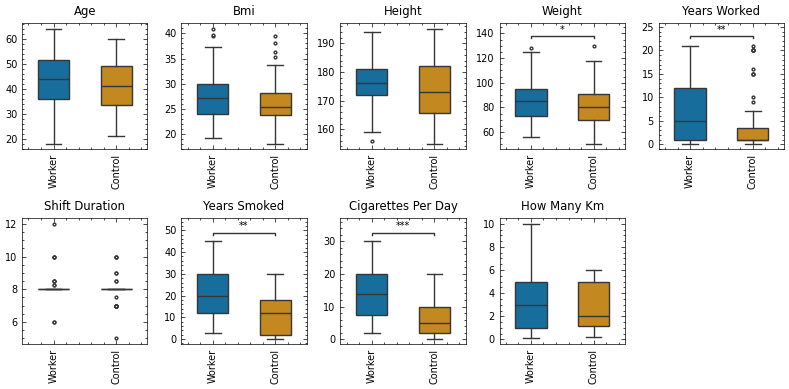

In [5]:
numeric_columns_1 = (
    df.select_dtypes("number")
    .sort_index(axis="columns")
    .loc[
        :,
        [
            "Age",
            "BMI",
            "height",
            "weight",
            "years_worked",
            "shift_duration",
            "years_smoked",
            "cigarettes_per_day",
            "how_many_km",
        ],
    ]
)


fig = plt.figure(figsize=(8, 4))
rows, cols = 2, 5

for idx, i in enumerate(numeric_columns_1.columns):
    pairs, p_values = common_functions.get_pairs_values_for_mannwhitneyu(
        data=df, value_var=i, id_vars=["Worker", "Control"], col="main_category"
    )

    fig.add_subplot(rows, cols, idx + 1)
    (
        df.loc[:, lambda df_: ["main_category", i]]
        .rename(columns=lambda df_: df_.replace("_", " ").title())
        .replace("_", " ", regex=True)
        .pipe(
            lambda df_: common_functions.return_sns_box(
                df=df_, x=df_["Main Category"], y=df[i], ax=fig.axes[idx]
            )
        )
    )

    fig.axes[idx].set_title(i.replace("_", " ").title())
    fig.axes[idx].set_xlabel("")
    fig.axes[idx].set_ylabel("")
    fig.axes[idx].grid(False)
    plt.xticks(rotation=90)
    fig.tight_layout()

    if p_values[0] < 0.05:
        annotator = Annotator(
            fig.axes[idx], pairs=pairs, data=df, x="main_category", y=i, verbose=False
        )
        annotator.configure(text_format="star", loc="inside", line_width=1, test=None)
        annotator.set_pvalues_and_annotate(p_values)
    else:
        continue

plt.suptitle("")

## Based on sub_categories

Text(0.5, 0.98, '')

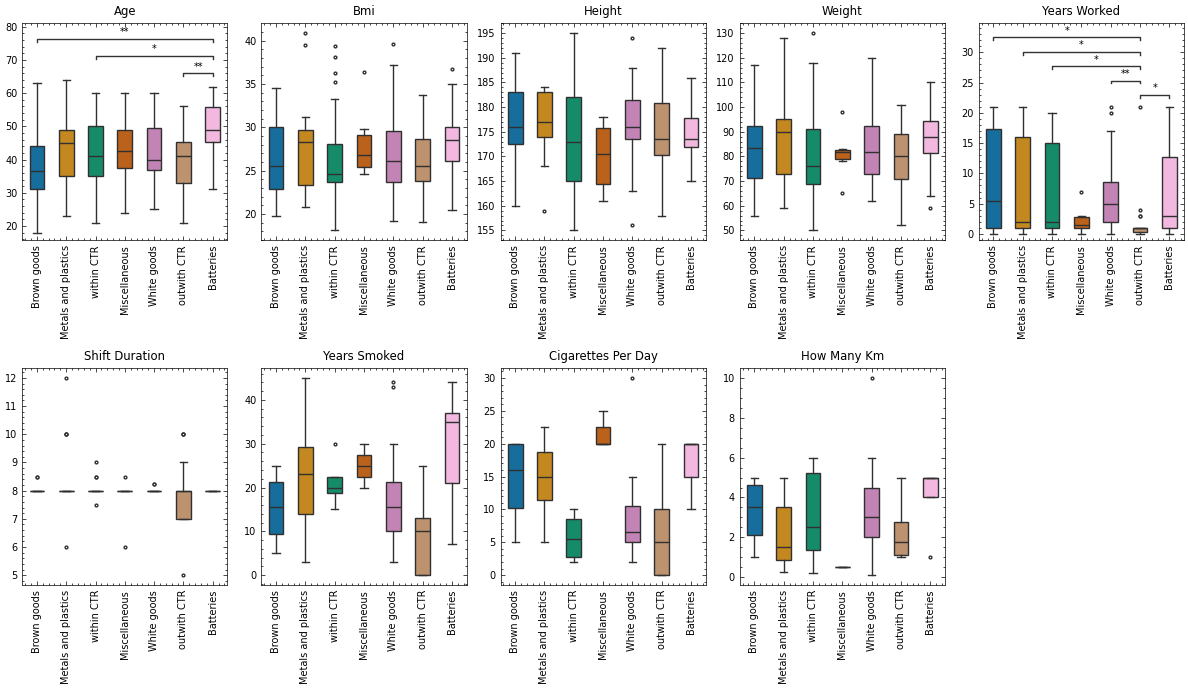

In [6]:
fig = plt.figure(figsize=(12, 7))
rows, cols = 2, 5

for idx, i in enumerate(numeric_columns_1.columns):
    pairs, p_values = common_functions.get_pairs_values_for_posthoc_dunn(
        data=df, value_vars=i, id_vars="sub_category"
    )

    fig.add_subplot(rows, cols, idx + 1)
    (
        df.loc[:, lambda df_: ["sub_category", i]]
        .rename(columns=lambda df_: df_.replace("_", " ").title())
        .replace("_", " ", regex=True)
        .pipe(
            lambda df_: common_functions.return_sns_box(
                df=df_, x=df_["Sub Category"], y=df[i], ax=fig.axes[idx]
            )
        )
    )

    fig.axes[idx].set_title(i.replace("_", " ").title())
    fig.axes[idx].set_xlabel("")
    fig.axes[idx].set_ylabel("")
    fig.axes[idx].grid(False)
    plt.xticks(rotation=90)
    fig.tight_layout()

    if len(pairs) >= 1:
        annotator = Annotator(
            fig.axes[idx], pairs, data=df, x="sub_category", y=i, verbose=False
        )
        annotator.configure(text_format="star", loc="inside", line_width=1, test=None)
        annotator.set_pvalues_and_annotate(p_values)
    else:
        continue

plt.suptitle("")

# Analyze Serum POPs Distribution

In [11]:
ORIGINAL_DATA_PATH = utils.Configuration.RAW_DATA_PATH.joinpath(
    "HBM4EU_E-waste_template_V3_all_data_2022_11_23.xlsx"
)

UA_POP_raw = pd.read_excel(
    ORIGINAL_DATA_PATH,
    sheet_name="E-waste study UA data",
    skiprows=3,
    nrows=172,
)

columns_to_keep = [
    "Worker ID (without letter 'E')",
    "PCB 28",
    "PCB 52",
    "PCB 101",
    "PCB 118",
    "PCB 138",
    "PCB 153",
    "PCB 180",
    "BDE 28 [2,4,4′-Tribromodiphenyl ether]",
    "BDE 47 [2,2′,4,4′-tetrabromodiphenyl ether]",
    "BDE 99",
    "BDE 100",
    "BDE 153",
    "BDE 154",
    "BDE 183",
    "BDE 209",
    "Dechlorane",
]

UA_POP_raw = (
    UA_POP_raw.loc[3:, lambda df_: ~df_.columns.str.contains("Unnamed")]
    .reset_index(drop=True)
    .loc[:, lambda df_: df_.columns.isin(columns_to_keep)]
    .rename(
        columns={
            "BDE 28 [2,4,4′-Tribromodiphenyl ether]": "BDE 28",
            "BDE 47 [2,2′,4,4′-tetrabromodiphenyl ether]": "BDE 47",
        }
    )
)
UA_POP_rawUA_POP_raw = df.loc[:, "PCB 28":]

## Detection frequencies of serum POPs

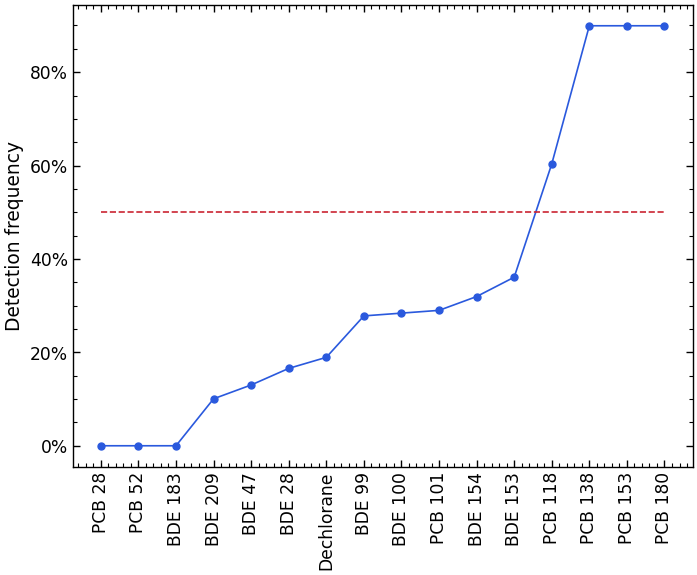

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

detection_freqency = (
    UA_POP_raw.loc[:, "PCB 28":]
    .pipe(lambda df_: df_.apply(pd.to_numeric, errors="coerce"))
    .notna()
    .sum()
    .div(UA_POP_raw.shape[0])
    # .mul(100)
    .sort_values(ascending=True)
)
(detection_freqency.plot(rot=90, ax=ax, style=["o-"], color="#2a59dd", markersize=5))
ax.set_xticks(range(UA_POP_raw.loc[:, "PCB 28":].columns.shape[0]))
ax.set_xticklabels(detection_freqency.index, ha="center")
ax.set_ylabel("Detection frequency")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.hlines(
    y=0.5,
    xmin=0,
    xmax=detection_freqency.index.shape[0] - 1,
    linestyles="--",
    color="#cb2532",
)

## Distribution of main congeners based on main categories

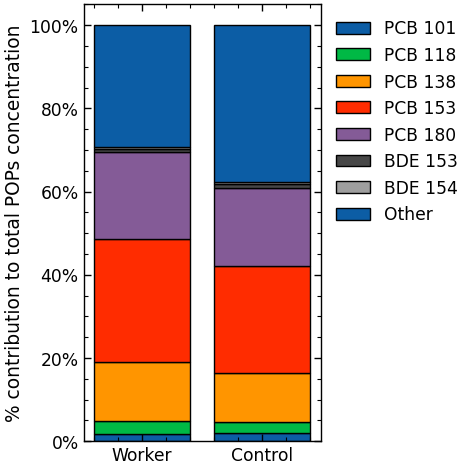

In [30]:
sumOfAll_maincat = (
    df.set_index("main_category")
    .loc[:, "PCB 28":]
    .reset_index()
    .assign(
        Other=lambda df: df.loc[
            :,
            lambda df: df.columns.isin(
                [
                    "PCB 28",
                    "PCB 52",
                    "BDE 183",
                    "BDE 209",
                    "BDE 47",
                    "BDE 28",
                    "Dechlorane",
                    "BDE 99",
                    "BDE 100",
                ]
            ),
        ].sum(axis="columns")
    )
    .loc[
        :,
        lambda df: ~df.columns.isin(
            [
                "PCB 28",
                "PCB 52",
                "BDE 183",
                "BDE 209",
                "BDE 47",
                "BDE 28",
                "Dechlorane",
                "BDE 99",
                "BDE 100",
            ]
        ),
    ]
    .groupby("main_category")
    .sum()
    .assign(sumOfAll=lambda df: df.loc[:, "PCB 101":].sum(axis="columns"))[["sumOfAll"]]
)

distribution_POP_maincat = (
    df.set_index("main_category")
    .loc[:, "PCB 28":]
    .reset_index()
    .assign(
        Other=lambda df: df.loc[
            :,
            lambda df: df.columns.isin(
                [
                    "PCB 28",
                    "PCB 52",
                    "BDE 183",
                    "BDE 209",
                    "BDE 47",
                    "BDE 28",
                    "Dechlorane",
                    "BDE 99",
                    "BDE 100",
                ]
            ),
        ].sum(axis="columns")
    )
    .loc[
        :,
        lambda df: ~df.columns.isin(
            [
                "PCB 28",
                "PCB 52",
                "BDE 183",
                "BDE 209",
                "BDE 47",
                "BDE 28",
                "Dechlorane",
                "BDE 99",
                "BDE 100",
            ]
        ),
    ]
    .groupby("main_category")
    .sum()
    .assign(sumOfAll=lambda df: df.loc[:, "PCB 101":].sum(axis="columns"))
    .div(sumOfAll_maincat.values, axis=1)
    # .mul(100)
    .loc[:, "PCB 101":"Other"]
    .rename(lambda index: index.replace("_", " ").title())
)


fig, axs = plt.subplots(figsize=(5, 5))

hatches = ["/", "\\", "|", "-", "+", "x", "o", "*"]

# distribution_POP_maincat.sort_index(ascending = False) was added to swap the order of worker vs control
for i in range(distribution_POP_maincat.shape[1]):
    plt.bar(
        x=distribution_POP_maincat.sort_index(ascending=False).index,
        height=distribution_POP_maincat.sort_index(ascending=False).iloc[:, i].values,
        label=distribution_POP_maincat.sort_index(ascending=False).columns[i],
        edgecolor="black",
        linewidth=1,
        bottom=np.sum(
            distribution_POP_maincat.sort_index(ascending=False).iloc[:, :i], axis=1
        ),
    )

axs.legend(bbox_to_anchor=(1, 1))
axs.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axs.set_ylabel("% contribution to total POPs concentration")
plt.tight_layout()

## Distribution of main congeners based on subcategories

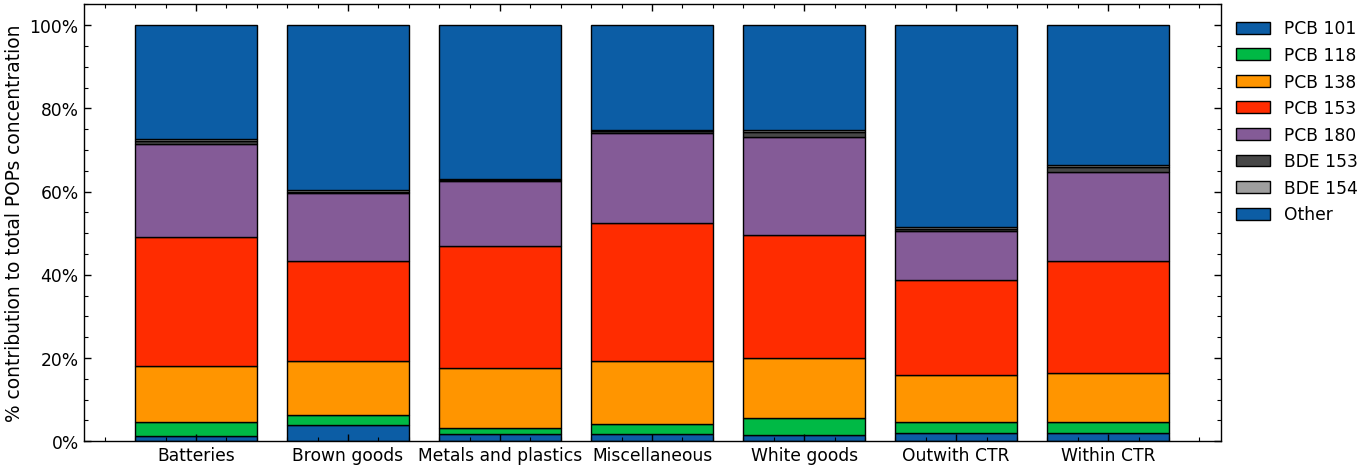

In [33]:
sumOfAll_subcat = (
    df.set_index("sub_category")
    .loc[:, "PCB 28":]
    .reset_index()
    .assign(
        Other=lambda df: df.loc[
            :,
            lambda df: df.columns.isin(
                [
                    "PCB 28",
                    "PCB 52",
                    "BDE 183",
                    "BDE 209",
                    "BDE 47",
                    "BDE 28",
                    "Dechlorane",
                    "BDE 99",
                    "BDE 100",
                ]
            ),
        ].sum(axis="columns")
    )
    .loc[
        :,
        lambda df: ~df.columns.isin(
            [
                "PCB 28",
                "PCB 52",
                "BDE 183",
                "BDE 209",
                "BDE 47",
                "BDE 28",
                "Dechlorane",
                "BDE 99",
                "BDE 100",
            ]
        ),
    ]
    .groupby("sub_category")
    .sum()
    .assign(sumOfAll=lambda df: df.loc[:, "PCB 101":].sum(axis="columns"))[["sumOfAll"]]
)

distribution_POP_subcat = (
    df.set_index("sub_category")
    .loc[:, "PCB 28":]
    .reset_index()
    .assign(
        Other=lambda df: df.loc[
            :,
            lambda df: df.columns.isin(
                [
                    "PCB 28",
                    "PCB 52",
                    "BDE 183",
                    "BDE 209",
                    "BDE 47",
                    "BDE 28",
                    "Dechlorane",
                    "BDE 99",
                    "BDE 100",
                ]
            ),
        ].sum(axis="columns")
    )
    .loc[
        :,
        lambda df: ~df.columns.isin(
            [
                "PCB 28",
                "PCB 52",
                "BDE 183",
                "BDE 209",
                "BDE 47",
                "BDE 28",
                "Dechlorane",
                "BDE 99",
                "BDE 100",
            ]
        ),
    ]
    .groupby("sub_category")
    .sum()
    .assign(sumOfAll=lambda df: df.loc[:, "PCB 101":].sum(axis="columns"))
    .div(sumOfAll_subcat.values, axis=1)
    # .mul(100)
    .loc[:, "PCB 101":"Other"]
    .rename(
        {
            "outwith_CTR": "Outwith CTR",
            "within_CTR": "Within CTR",
        }
    )
)


fig, axs = plt.subplots(figsize=(14, 5))

hatches = ["/", "\\", "|", "-", "+", "x", "o", "*"]

for i in range(distribution_POP_subcat.shape[1]):
    plt.bar(
        x=distribution_POP_subcat.index,
        height=distribution_POP_subcat.iloc[:, i].values,
        label=distribution_POP_subcat.columns[i],
        edgecolor="black",
        linewidth=1,
        bottom=np.sum(distribution_POP_subcat.iloc[:, :i], axis=1),
    )
plt.legend()
axs.legend(bbox_to_anchor=(1, 1))
axs.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axs.set_ylabel("% contribution to total POPs concentration")
plt.tight_layout()